# Assignment 2

In [67]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# DATA IMPORT - FROM GITHUB
data_raw = pd.read_csv('https://raw.githubusercontent.com/thimaipham/2.CEU_DA3_Assignment2/main/listings.csv')

### 1. Data Featuring

##### Data describe:
- The raw dataset comprises 25,480 observations and 76 columns, including some columns that are unnecessary or difficult to use during the modeling process.
- Certain important columns are encountering the following issues:
    1. The `bedrooms` column has a staggering 99% missing values.
    2. The `name` column contains descriptions of apartments, including the number of bedrooms.
    3. The `bathrooms` column has no data.
    4. The `bathroom_text` column has data but is currently of object type due to the presence of the word 'bath' in the entries.
    5. The `price` column is currently of object type as it contains the '$' symbol.


- Several columns exhibit a high percentage of missing values (ranging from 40% to 90%).

In [3]:
# Regex looks for a number followed by the word 'bedroom' or 'bedrooms'
data_raw['bedroom_extract'] = data_raw['name'].str.extract('(\d+) bedroom')

# Convert the extracted bedroom numbers to numeric type
data_raw['bedroom_extract'] = pd.to_numeric(data_raw['bedroom_extract'], errors='coerce')

In [4]:
# Removing unnecessary columns to streamline the dataset for this assignment
# List of columns to be dropped based on the description and analysis
columns_to_drop = [
    'id', 'listing_url', 'scrape_id', 'name', 'last_scraped', 'description',
    'neighborhood_overview', 'picture_url', 'host_id', 'host_url','bedrooms','host_name', 
    'host_thumbnail_url', 'host_picture_url', 'host_about', 'host_neighbourhood',
    'host_listings_count', 'host_total_listings_count', 'neighbourhood', 
    'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'calendar_last_scraped', 
    'license', 'host_location', 'source','first_review','last_review','host_verifications',
    'calendar_updated', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 
    'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 
    'amenities' # amenities column is emty with [] symbol
]

# Dropping the columns from the DataFrame
data_cleaned = data_raw.drop(columns=columns_to_drop, errors='ignore')

# We focus on apartments with 2<= n <= 6
data_cleaned = data_cleaned[(data_cleaned.accommodates >= 2) & (data_cleaned.accommodates <= 6)]

# Removing rows with null values in the 'price' variable for accurate modeling
data_cleaned = data_cleaned.dropna(subset=['price'])


In [5]:
# Convert 'bathrooms_text' to a numeric 'bathrooms' column by extracting the number
data_cleaned['bathrooms'] = data_cleaned['bathrooms_text'].str.extract('(\d+)').astype(float)

# Convert 'price' to a numeric column by removing the '$' and ',' then converting to float
data_cleaned['price'] = data_cleaned['price'].replace('[\$,]', '', regex=True).astype(float)

# Drop the original 'bathrooms_text' column as it's now redundant
data_cleaned = data_cleaned.drop('bathrooms_text', axis=1)



In [6]:
# Calculate the percentage of missing values for each column
missing_percentage = data_cleaned.isnull().mean() * 100

# Due to some columns which have more than 40% of missing values, I will drop those columns
# Identify columns with more than 40% missing values
columns_to_drop_missing = missing_percentage[missing_percentage > 40].index

# Drop these columns
data_cleaned = data_cleaned.drop(columns=columns_to_drop_missing)

# Drop observations with any missing values
data_cleaned = data_cleaned.dropna()

##### After cleaning part the cleaned data includes: 
- 13773 observations
- 38 columns

### 2. Data featuring

##### Dealing with catergorical variables

In [7]:
# Convert binary categorical variables to 0 and 1
binary_vars = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
data_cleaned[binary_vars] = data_cleaned[binary_vars].apply(lambda x: x.map({'t': 1, 'f': 0}))

# Extract number of days since the host joined
data_cleaned['host_since'] = pd.to_datetime(data_cleaned['host_since'])
data_cleaned['days_since_host_joined'] = (pd.to_datetime('today') - data_cleaned['host_since']).dt.days

# Reset index of the original data to ensure consistent indexing before one-hot encoding
data_cleaned_reset = data_cleaned.reset_index(drop=True)

# One-hot encoding 'room_type'
encoder_room_type = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_room_types = encoder_room_type.fit_transform(data_cleaned_reset[['room_type']])
encoded_room_type_names = encoder_room_type.get_feature_names_out(['room_type'])

# Create a DataFrame for the encoded room type features with index aligned to the original data
encoded_room_type_df = pd.DataFrame(encoded_room_types, columns=encoded_room_type_names, index=data_cleaned_reset.index)

# Concatenate the one-hot encoded features and drop the original 'room_type' column with aligned indices
data_preprocessed = pd.concat([data_cleaned_reset.drop(['room_type'], axis=1), encoded_room_type_df], axis=1)

# Display the first few rows to confirm changes
data_preprocessed


,host_since,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,property_type,accommodates,bathrooms,beds,...,review_scores_location,review_scores_value,instant_bookable,reviews_per_month,bedroom_extract,days_since_host_joined,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,2015-07-22,1,1,1,-34.082650,151.148550,Private room in guesthouse,2,1.0,1.0,...,4.97,4.83,1,1.86,1.0,3126,0.0,0.0,1.0,0.0
1,2017-10-17,0,1,1,-33.758380,151.287420,Entire guesthouse,5,1.0,3.0,...,5.00,5.00,0,0.03,2.0,2308,1.0,0.0,0.0,0.0
2,2016-07-20,1,1,1,-33.905680,151.206990,Entire rental unit,3,1.0,2.0,...,4.80,4.73,1,1.34,2.0,2762,1.0,0.0,0.0,0.0
3,2023-05-28,0,1,1,-33.883860,151.180388,Private room in home,2,1.0,2.0,...,4.58,4.33,0,6.43,1.0,259,0.0,0.0,1.0,0.0
4,2015-05-20,0,1,1,-33.886420,151.170760,Private room in hostel,2,1.0,1.0,...,4.68,4.80,1,1.88,1.0,3189,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13768,2015-09-08,0,1,1,-33.877990,151.245680,Entire rental unit,2,1.0,1.0,...,5.00,5.00,0,0.52,1.0,3078,1.0,0.0,0.0,0.0
13769,2019-02-16,0,1,1,-33.958960,151.023090,Entire guesthouse,4,1.0,2.0,...,4.72,4.63,1,2.72,1.0,1821,1.0,0.0,0.0,0.0
13770,2017-04-07,0,1,1,-33.832000,151.240590,Entire rental unit,4,1.0,2.0,...,4.50,5.00,0,0.56,1.0,2501,1.0,0.0,0.0,0.0
13771,2015-07-13,0,1,1,-33.898658,151.196823,Entire home,6,2.0,3.0,...,5.00,5.00,0,1.00,3.0,3135,1.0,0.0,0.0,0.0


##### Grouping features

In [9]:
# Basic variables
basic_vars = [
    "accommodates",
    "beds",
    "bedroom_extract",
    "bathrooms"
]

# Host-related features
host_related = [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified"
]

# Time-related feature 
time_related = ["days_since_host_joined"]

# Review-related features 
reviews = [
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
    "number_of_reviews",
    "reviews_per_month"
]

# Availability-related features
availability_related = [
    "availability_30",
    "availability_60",
    "availability_90",
    "availability_365"
]

# Reviews features
number_of_reviews_related = [
    "number_of_reviews",
    "number_of_reviews_ltm",
    "number_of_reviews_l30d"
]

# Room type features
room_type_feature = [col for col in data_preprocessed.columns if 'room_type' in col]

# Combining all the features for a comprehensive model
all_features = (
    basic_vars +
    host_related +
    time_related +
    reviews +
    availability_related +
    number_of_reviews_related +
    room_type_feature
)

# Confirm the total number of unique features for the updated comprehensive model
len(set(all_features))


27

In [10]:
data_preprocessed.to_csv('data_preprocessed.csv', index=False)

##### Split data to train and test

In [13]:
# Split the data into training and test sets
X = data_preprocessed[all_features] 
y = data_preprocessed['price']

# Perform the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sizes of the training and test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11018, 28), (2755, 28), (11018,), (2755,))

### OSL

In [49]:
# Function to train and evaluate a model
def ols_train_and_evaluate(X_train, X_test, y_train, y_test, features):
    # Create and train the model
    model = LinearRegression()
    model.fit(X_train[features], y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train[features])
    y_pred_test = model.predict(X_test[features])
    
    # Evaluation
    mse_train = round(mean_squared_error(y_train, y_pred_train), 3)
    mse_test = round(mean_squared_error(y_test, y_pred_test),3)
    rmse_train = round(sqrt(mse_train), 3)
    rmse_test = round(sqrt(mse_test),3)
    mae_train = round(mean_absolute_error(y_train, y_pred_train), 3)
    mae_test = round(mean_absolute_error(y_test, y_pred_test), 3)
    r2_train = round(r2_score(y_train, y_pred_train), 3)
    r2_test = round(r2_score(y_test, y_pred_test), 3)
    
    return {
        "RMSE_Train": rmse_train,
        "RMSE_Test": rmse_test,
        "R2_Train": r2_train,
        "R2_Test": r2_test
    }


##### Model 1: `basic_vars` focuses on basic features to establish a baseline performance

In [50]:
# Model 1: Simple: 
model_1_features = basic_vars
ols_1_results = ols_train_and_evaluate(X_train, X_test, y_train, y_test, model_1_features)

ols_1_results

{'RMSE_Train': 372.874,
 'RMSE_Test': 182.435,
 'R2_Train': 0.081,
 'R2_Test': 0.25}

##### Model 2: `basic_vars` +  `host_related` + `time_related`  introduces host and time-related variables to examine if host characteristics and tenure impact price predictions.

In [51]:
# Model 2: Intermediate
model_2_features = basic_vars + host_related + time_related
ols_2_results = ols_train_and_evaluate(X_train, X_test, y_train, y_test, model_2_features)

ols_2_results


{'RMSE_Train': 371.824,
 'RMSE_Test': 180.625,
 'R2_Train': 0.086,
 'R2_Test': 0.264}

##### Model 3: `all_features`  leverages the full spectrum of available data to maximize predictive accuracy, testing the hypothesis that a more detailed feature set can provide better predictions.

In [52]:
# Model 3: Complex
model_3_features = all_features  
ols_3_results = ols_train_and_evaluate(X_train, X_test, y_train, y_test, model_3_features)

ols_3_results


{'RMSE_Train': 366.901,
 'RMSE_Test': 171.448,
 'R2_Train': 0.11,
 'R2_Test': 0.337}

- Model Selection Rationale: We chose models of increasing complexity to evaluate how adding more features affects model performance. Starting with basic property attributes, then incorporating host and time-related features, and finally using a comprehensive set of features including reviews and availability.

- Complexity vs. Accuracy: While the most complex model (Model 3) achieved the best performance, the improvement in R^2 from Model 2 to Model 3 suggests diminishing returns from adding more features.


- Improvement across models: There's a noticeable improvement in both RMSE and R² as we move from a simple model to a complex model. The complex model, which includes all specified features, yields the best performance in terms of both lower RMSE (indicating better accuracy) and higher R² (indicating a better fit of the model to the data).
- Training vs. Testing performance: For all models, the RMSE is higher on the training set compared to the testing set. This is somewhat unusual, as we'd typically expect the model to perform better on the data it was trained on. However, this can sometimes occur due to the random split of data, the nature of the dataset, or when the model is very simple compared to the complexity of the task.
- Room for improvement: Despite the improvements, the R² values suggest that there's still a significant portion of variance in the rental prices that the models are not capturing. This indicates potential room for further model refinement, feature engineering, or the exploration of more complex modeling approaches.

### Random Forest

- Performance Improvement: Each successive model shows a reduction in RMSE, indicating a more accurate prediction as we move from simple to complex models. The Random Forest model significantly outperforms all linear regression models in terms of RMSE, indicating higher accuracy.

- Overfitting Concern: Despite the Random Forest model's superior performance on the training set (R^2 = 0.83), the test set performance (R^2 = 0.39) suggests potential overfitting. **gây ra  học quá mức từ dữ liệu huấn luyện và do đó, kém khả năng tổng quát hóa tốt trên dữ liệu mới.**

- Model Selection Rationale: The choice to progress from simple linear models to a complex Random Forest was driven by the desire to capture non-linear relationships and interactions between features that linear models may miss. The improvement in both RMSE and R^2 scores in the Random Forest model suggests that it is better suited for this dataset, thanks to its ability to handle feature interactions and heterogeneity in the data.

- Khi so sánh với các mô hình hồi quy tuyến tính trước đó, Random Forest cải thiện đáng kể lỗi trung bình bình phương (MSE) và điểm R^2 trên tập huấn luyện, nhưng chỉ số R^2 trên tập kiểm tra cho thấy mô hình này không hoàn toàn vượt trội trong việc dự đoán giá trên dữ liệu chưa từng thấy.

In [53]:
def rf_train_and_evaluate(X_train, X_test, y_train, y_test, n_estimators=100, random_state=42):
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)
    rf_model.fit(X_train, y_train)
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)

    # Calculate RMSE and R2 for the training set
    rmse_train = round(np.sqrt(mean_squared_error(y_train, y_pred_train)),3)
    r2_train = round(r2_score(y_train, y_pred_train),3)

    # Calculate RMSE and R2 for the testing set
    rmse_test = round(np.sqrt(mean_squared_error(y_test, y_pred_test)),3)
    r2_test = round(r2_score(y_test, y_pred_test),3)

    results = {
        'RMSE_Train': rmse_train,
        'RMSE_Test': rmse_test,
        'R2_Train': r2_train,
        'R2_Test': r2_test
    }

    return results


In [54]:
# Run the Random Forest model
rf_results = rf_train_and_evaluate(X_train, X_test, y_train, y_test)
rf_results

{'RMSE_Train': 161.256,
 'RMSE_Test': 169.134,
 'R2_Train': 0.828,
 'R2_Test': 0.355}

- General Performance: The Random Forest model demonstrated a good balance between training and testing performance, indicating a robust model with better generalization capabilities compared to the OLS model. Specifically, the Random Forest model achieved a lower RMSE and higher R² on the testing set, suggesting it was more accurate and explained more variance in the data.
- Overfitting: While there is a noticeable difference between training and testing metrics (RMSE and R²), indicating some level of overfitting, the Random Forest model still managed to perform relatively well on unseen data. 

### CART

In [55]:
# Initialize  and fit model
cart_model = DecisionTreeRegressor(random_state=42)
cart_model.fit(X_train, y_train)

# Predictions on both the training and testing sets
y_pred_train_cart = cart_model.predict(X_train)
y_pred_test_cart = cart_model.predict(X_test)

# Calculate RMSE and R2 for the training set
rmse_train_cart = round(np.sqrt(mean_squared_error(y_train, y_pred_train_cart)),3)
r2_train_cart = round(r2_score(y_train, y_pred_train_cart),3)

# Calculate RMSE and R² for the testing set
rmse_test_cart = round(np.sqrt(mean_squared_error(y_test, y_pred_test_cart)),3)
r2_test_cart = round(r2_score(y_test, y_pred_test_cart),3)

cart_results = {
    "RMSE_Train": rmse_train_cart,
    "RMSE_Test": rmse_test_cart,
    "R2_Train": r2_train_cart,
    "R2_Test": r2_test_cart
}

cart_results

{'RMSE_Train': 2.293, 'RMSE_Test': 308.459, 'R2_Train': 1.0, 'R2_Test': -1.145}

- Overfitting: The CART model demonstrates a significant overfitting issue, as indicated by nearly perfect performance on the training set (RMSE close to 0 and R² almost 1) but poor performance on the testing set. The RMSE is significantly higher on the test set, and the R² value is negative, indicating that the model performs worse than a simple horizontal line drawn at the mean of the target values.
- Model Complexity: The decision tree has likely grown too complex, capturing noise and specific patterns in the training data that do not generalize well to unseen data. This is a common challenge with decision trees, where they can become highly tailored to the training data without proper constraints (like limiting the depth of the tree).

## Gadient Boosting model

In [56]:
# Initialize and fit model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Predictions on both the training and testing sets
y_pred_train_gb = gb_model.predict(X_train)
y_pred_test_gb = gb_model.predict(X_test)

# Calculate RMSE and R2 for the training set
rmse_train_gb = round(np.sqrt(mean_squared_error(y_train, y_pred_train_gb)),3)
r2_train_gb = round(r2_score(y_train, y_pred_train_gb), 3)

# Calculate RMSE and R2 for the testing set
rmse_test_gb = round(np.sqrt(mean_squared_error(y_test, y_pred_test_gb)), 3)
r2_test_gb = round(r2_score(y_test, y_pred_test_gb), 3)

gb_results = {
    "RMSE_Train": rmse_train_gb,
    "RMSE_Test": rmse_test_gb,
    "R2_Train": r2_train_gb,
    "R2_Test": r2_test_gb
}

gb_results

{'RMSE_Train': 311.753,
 'RMSE_Test': 177.357,
 'R2_Train': 0.358,
 'R2_Test': 0.291}

- Model Performance: The Gradient Boosting model shows a significant improvement in RMSE on the test set compared to the training set, indicating a better balance between bias and variance than the CART model we observed earlier.
- Generalization Capability: The model's ability to maintain a relatively lower RMSE on the test set suggests it has a decent generalization capability, especially in comparison to the CART model which showed signs of overfitting.
- R² Values: Although the R² values indicate that the model explains a moderate proportion of the variance in the target variable, there's room for improvement in how well the model fits the data.

## Findings and Discussions:

In [57]:
results_df = pd.DataFrame({
    "OLS Model 1": ols_1_results,
    "OLS Model 2": ols_2_results,
    "OLS Model 3": ols_3_results,
    "Random Forest": rf_results,
    "CART": cart_results,
    "Gadient Boosting": gb_results
})

results_df

,OLS Model 1,OLS Model 2,OLS Model 3,Random Forest,CART,Gadient Boosting
RMSE_Train,372.874,371.824,366.901,161.256,2.293,311.753
RMSE_Test,182.435,180.625,171.448,169.134,308.459,177.357
R2_Train,0.081,0.086,0.110,0.828,1.000,0.358
R2_Test,0.250,0.264,0.337,0.355,-1.145,0.291


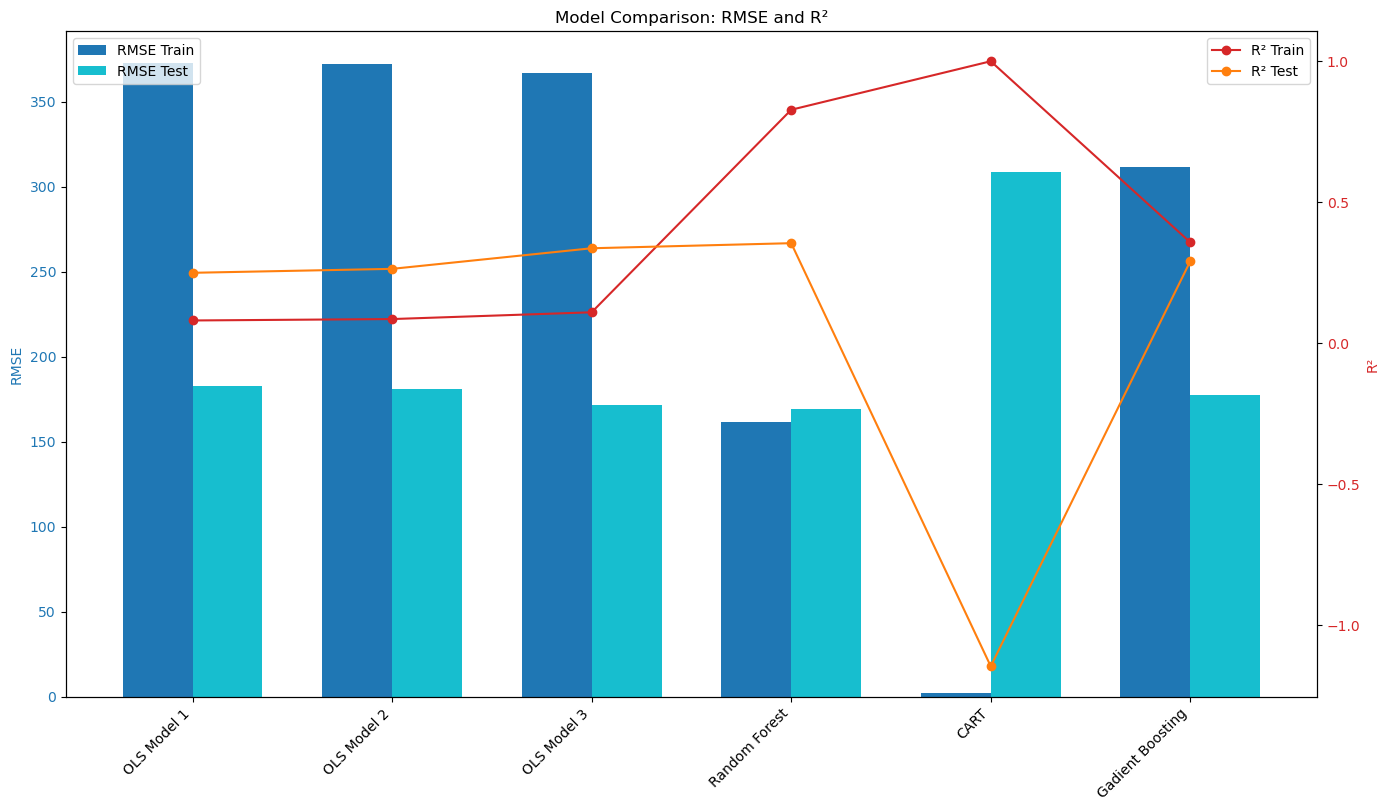

In [71]:
# Extracting RMSE and R2 values and set-up plot
rmse_train = results_df.loc['RMSE_Train']
r2_train = results_df.loc['R2_Train']
rmse_test = results_df.loc['RMSE_Test']
r2_test = results_df.loc['R2_Test']
models = results_df.columns 
x_indexes = np.arange(len(models)) 
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar plots for RMSE
bar_width = 0.35
ax1.bar(x_indexes - bar_width/2, rmse_train, width=bar_width, label='RMSE Train', color='tab:blue')
ax1.bar(x_indexes + bar_width/2, rmse_test, width=bar_width, label='RMSE Test', color='tab:cyan')
ax1.set_ylabel('RMSE', color='tab:blue')
ax1.set_xticks(x_indexes)
ax1.set_xticklabels(models, rotation=45, ha="right")
ax1.legend(loc='upper left')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Line plots for R2
ax2 = ax1.twinx()
ax2.set_ylabel('R²', color='tab:red')
ax2.plot(models, r2_train, label='R² Train', color='tab:red', marker='o')
ax2.plot(models, r2_test, label='R² Test', color='tab:orange', marker='o')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.title('Model Comparison: RMSE and R²')
plt.show()

- RMSE (Training vs. Testing): All models, except CART, show a reasonable balance between training and testing RMSE values. CART, however, shows a significant overfitting with an extremely low training RMSE compared to the testing RMSE.
- R² (Training vs. Testing): Similar to RMSE, the R² values indicate how well the models fit the data. The CART model demonstrates almost perfect fit on the training data but performs poorly on the testing data, further indicating overfitting. The other models show more balanced R² values, though still indicate room for improvement in model fit and generalization.
- General Performance: The Random Forest and Gradient Boosting models show a better balance between training and testing performance, suggesting they are more robust and generalize better than the OLS and CART models. Gradient Boosting, in particular, shows a promising trade-off between underfitting and overfitting, making it a strong candidate for further tuning and optimization.
##### Conclusion:
- Model Selection: Based on these results, Gradient Boosting appears to be the most promising model, offering a good balance between accuracy and generalization. Random Forest also shows good potential.
- Overfitting Concerns: The CART model's performance highlights the importance of controlling for overfitting, especially when using single decision trees.

### Feature Importance

##### RANDOM FOREST MODEL

In [104]:
# RANDOM FOREST MODEL
feature_importances = rf_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# GRADIENT BOOSTING
feature_importances_gb = gb_model.feature_importances_
features_gb = X_train.columns
importance_df_gb = pd.DataFrame({'Feature': features_gb, 'Importance': feature_importances_gb})
importance_df_gb = importance_df_gb.sort_values(by='Importance', ascending=False)


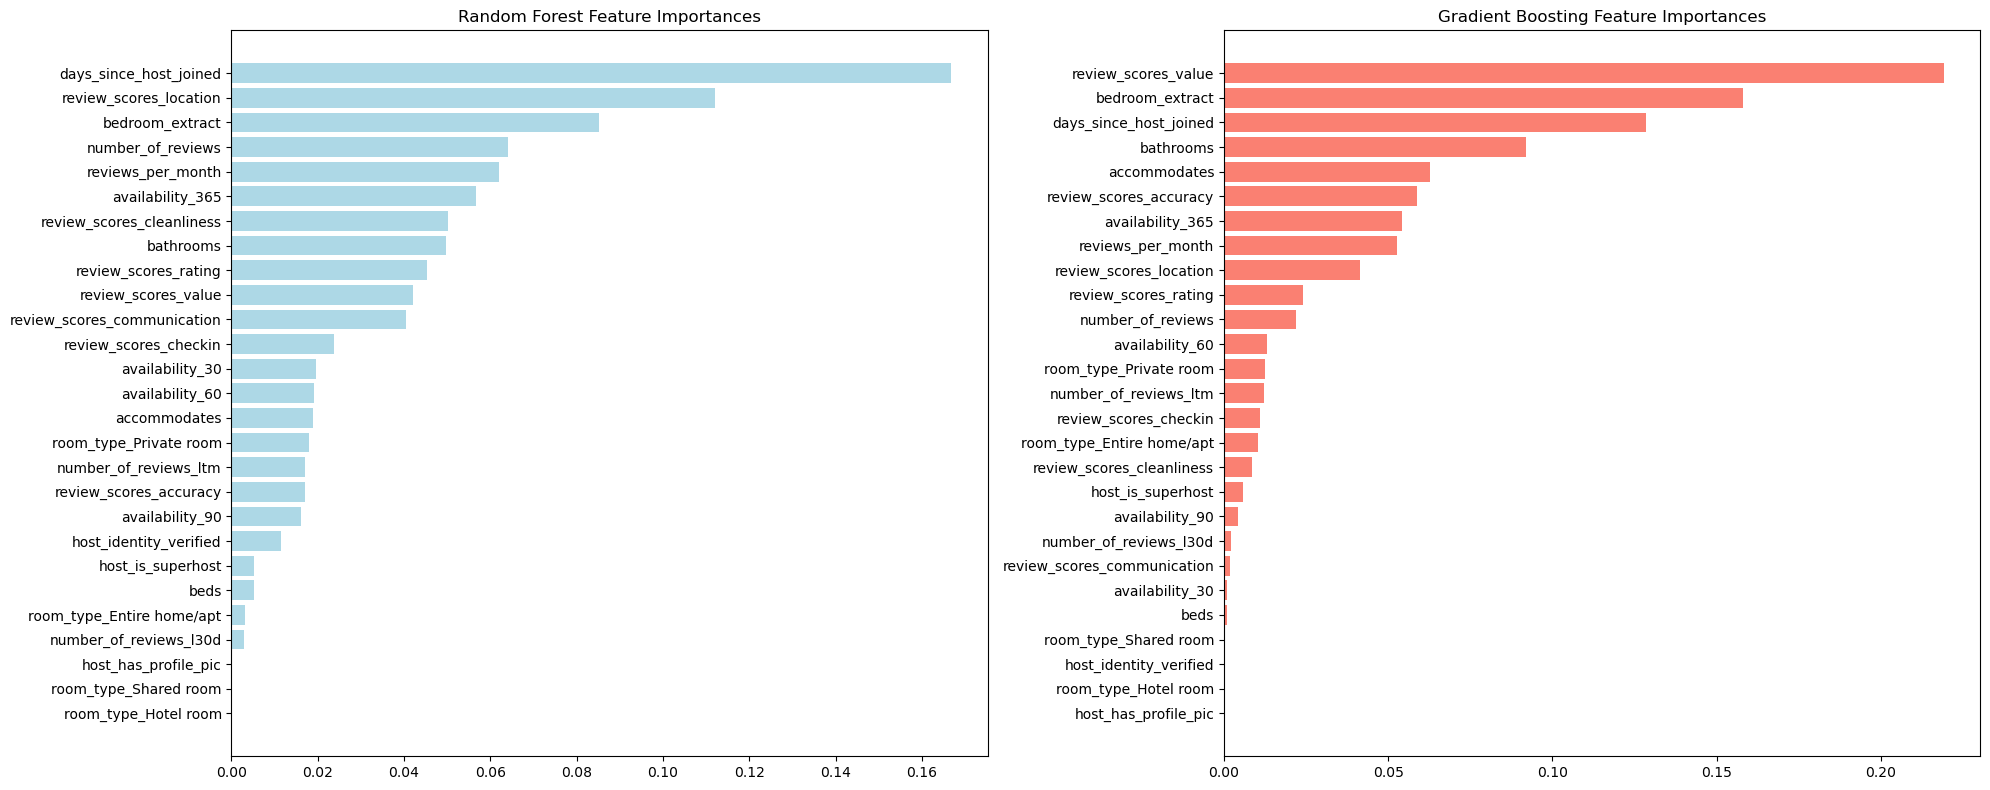

In [105]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

# Plot for Random Forest
axes[0].barh(importance_df_rf['Feature'], importance_df_rf['Importance'], color='lightblue')
axes[0].set_title('Random Forest Feature Importances')
axes[0].invert_yaxis()

# Plot for Gradient Boosting
axes[1].barh(importance_df_gb['Feature'], importance_df_gb['Importance'], color='salmon')
axes[1].set_title('Gradient Boosting Feature Importances')
axes[1].invert_yaxis() 

plt.tight_layout()
plt.show()

Từ plot trên có thể nhận thấy ở cả mô hình Random Forest và mô hình Gradient Boosting thì `day_since_host_joined`, `review_score_value`, `review_score_location` và `bath_room` đều là những yếu tố quan trọng ảnh hướng tới giá của một small and mid-size apartments hosting 2-6 guests